## This notebook is part of the Spark training delivered by IT-DB group
### SPARK SQL Hands-On Lab
by Prasanth Kothuri, Luca Canali

### Hands-On - Data exploration and analysis using Spark SQL
*This demostrates how to use Spark SQL - filter, aggregates and joins*

#### First let's create a Spark Session
*Use this notebook from Jupyter with Python kernel*  
*When using CERN SWAN, do not attach the notebook to a Spark cluster, but rather run locally on the SWAN container*  
*If running this outside CERN SWAN, make sure you have pyspark, or install it with* `pip install pyspark`

In [1]:
# Create Spark Session, you need this to work with Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .appName("my app")  \
        .master("local[1]") \
        .config("spark.driver.memory","1g") \
        .getOrCreate()


In [2]:
spark

### Some basic Spark SQL to get started

In [3]:
# What you can do with DataFrame declarative API you can also do with Spark SQL.  
# This uses the DataFrame API:

df = spark.range(10)
df.show()
df.count()

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
+---+



10

In [4]:
# This uses Spark SQL
df2 = spark.sql("select id from range(10)")
df2.count()

10

In [5]:
# From DataFrame to Spark SQL View

df = spark.createDataFrame([(1, "event1"), (2,"event2"), (3, "event3")], ("id","name"))
df.createOrReplaceTempView("myEvents")

spark.sql("select count(*) from myEvents").show()

+--------+
|count(1)|
+--------+
|       3|
+--------+



In [6]:
# Execution plans
spark.sql("select * from myEvents where id=1").explain(True)

== Parsed Logical Plan ==
'Project [*]
+- 'Filter ('id = 1)
   +- 'UnresolvedRelation `myEvents`

== Analyzed Logical Plan ==
id: bigint, name: string
Project [id#20L, name#21]
+- Filter (id#20L = cast(1 as bigint))
   +- SubqueryAlias `myevents`
      +- LogicalRDD [id#20L, name#21], false

== Optimized Logical Plan ==
Filter (isnotnull(id#20L) && (id#20L = 1))
+- LogicalRDD [id#20L, name#21], false

== Physical Plan ==
*(1) Filter (isnotnull(id#20L) && (id#20L = 1))
+- Scan ExistingRDD[id#20L,name#21]


In [7]:
# Another syntax to create test tables
df = spark.sql("select * from values (1, 'event1'), (2,'event2'), (3, 'event3') as (id,name)")

# this will cache the table lazily
# it will be cached only after the first access, that's why we add df.count()
df.cache()
df.count()

# this registers a temporary view called t1
df.createOrReplaceTempView("t1")

# list the tables and views in the catalog
spark.catalog.listTables()

[Table(name='myevents', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='t1', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [8]:
# Show the table schema, with 2 different methods

df.printSchema()
spark.sql("describe t1").show()

root
 |-- id: integer (nullable = false)
 |-- name: string (nullable = false)

+--------+---------+-------+
|col_name|data_type|comment|
+--------+---------+-------+
|      id|      int|   null|
|    name|   string|   null|
+--------+---------+-------+



In [9]:
# Selection with calculated columns
spark.sql("select id, name, id % 2 even_or_odd from t1").show()

# Selection and filter
spark.sql("select id, name, id % 2 even_or_odd from t1 where id < 3").show()

# Aggregations
spark.sql("""select id % 2 as Even_or_odd, count(*) N_samples, sum(id) Sum_Ids 
       from t1 
       group by id % 2""").show()


+---+------+-----------+
| id|  name|even_or_odd|
+---+------+-----------+
|  1|event1|          1|
|  2|event2|          0|
|  3|event3|          1|
+---+------+-----------+

+---+------+-----------+
| id|  name|even_or_odd|
+---+------+-----------+
|  1|event1|          1|
|  2|event2|          0|
+---+------+-----------+

+-----------+---------+-------+
|Even_or_odd|N_samples|Sum_Ids|
+-----------+---------+-------+
|          1|        2|      4|
|          0|        1|      2|
+-----------+---------+-------+



In [10]:
# A helper "magic funxtion" for running PySpark SQL in Jupyter Notebooks

from IPython.core.magic import register_line_cell_magic
max_show_lines = 50         # Limit on the number of lines to show with %sql_show and %sql_display
@register_line_cell_magic
def sql_display(line, cell=None):
    """Execute sql and convert results to Pandas DataFrame for pretty display or further processing.
    Use: %sql_display or %%sql_display"""
    val = cell if cell is not None else line 
    return spark.sql(val).limit(max_show_lines).toPandas() 

In [12]:
%%sql_display

select id % 2 as Even_or_odd, count(*) N_samples, sum(id) Sum_Ids 
from t1 
group by id % 2

Even_or_odd  N_samples  Sum_Ids
0            1          2        4
1            0          1        2

In [13]:
# Fun with SQL: FizzBuzz, see https://en.wikipedia.org/wiki/Fizz_buzz
spark.sql("""
select case
    when id % 15 = 0 then 'FizzBuzz'
    when id % 3 = 0 then 'Fizz'
    when id % 5 = 0 then 'Buzz'
    else cast(id as string)
    end as FizzBuzz
from range(1,20)
order by id""").show()

+--------+
|FizzBuzz|
+--------+
|       1|
|       2|
|    Fizz|
|       4|
|    Buzz|
|    Fizz|
|       7|
|       8|
|    Fizz|
|    Buzz|
|      11|
|    Fizz|
|      13|
|      14|
|FizzBuzz|
|      16|
|      17|
|    Fizz|
|      19|
+--------+



In [14]:
# Join example using a parent-child relationship

# Create test tables
emp = spark.createDataFrame([(1, "Emp1", 10), (2,"Emp2", 10), (3, "Emp3", 20)], ("id","name","dep_id"))
emp.createOrReplaceTempView("employees")

dep = spark.createDataFrame([(10, "Department1"), (20, "Department2"), (30, "Department3")], ("id","name"))
dep.createOrReplaceTempView("departments")

In [15]:
# Inner join
spark.sql("""
select employees.id, employees.name emp_name, departments.name dep_name
from employees join departments
on employees.dep_id = departments.id
order by employees.id""").toPandas()

id emp_name     dep_name
0   1     Emp1  Department1
1   2     Emp2  Department1
2   3     Emp3  Department2

In [16]:
# Outer join
spark.sql("""
select departments.id, departments.name dep_name, employees.name emp_name
from departments left outer join employees
on employees.dep_id = departments.id
order by departments.id""").toPandas()

id     dep_name emp_name
0  10  Department1     Emp1
1  10  Department1     Emp2
2  20  Department2     Emp3
3  30  Department3     None

In [17]:
# Python UDF example
import time
def slowf(s):
  time.sleep(1)
  return 2*s

spark.udf.register("slowf", slowf)

# warmup
spark.sql("select slowf(1)").show()

%time spark.sql("select slowf(1)").show()

%time spark.sql("select slowf(id) from range(10)").show()

+--------+
|slowf(1)|
+--------+
|       2|
+--------+

+--------+
|slowf(1)|
+--------+
|       2|
+--------+

CPU times: user 3.33 ms, sys: 183 µs, total: 3.51 ms
Wall time: 1.09 s
+---------+
|slowf(id)|
+---------+
|        0|
|        2|
|        4|
|        6|
|        8|
|       10|
|       12|
|       14|
|       16|
|       18|
+---------+

CPU times: user 5.4 ms, sys: 137 µs, total: 5.53 ms
Wall time: 10.2 s


In [18]:
# Python Pandas UDF example
import time
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import LongType

def multiply_func(a, b):
  time.sleep(1)
  return a * b

multiply = pandas_udf(multiply_func, returnType=LongType())
spark.udf.register("multiply_func", multiply)

# warmup
spark.sql("select multiply_func(1,1)").show()

%time spark.sql("select multiply_func(1,1)").show()
%time spark.sql("select multiply_func(id,2) from range(10)").show()
%time a=spark.sql("select multiply_func(id,2) from range(10000)").collect()


+-------------------+
|multiply_func(1, 1)|
+-------------------+
|                  1|
+-------------------+

+-------------------+
|multiply_func(1, 1)|
+-------------------+
|                  1|
+-------------------+

CPU times: user 2.84 ms, sys: 1.3 ms, total: 4.14 ms
Wall time: 1.13 s
+--------------------+
|multiply_func(id, 2)|
+--------------------+
|                   0|
|                   2|
|                   4|
|                   6|
|                   8|
|                  10|
|                  12|
|                  14|
|                  16|
|                  18|
+--------------------+

CPU times: user 3.74 ms, sys: 259 µs, total: 4 ms
Wall time: 1.27 s
CPU times: user 49.1 ms, sys: 2.31 ms, total: 51.4 ms
Wall time: 1.3 s


## Examples with datasets
The following examples use sample data provided in the repository.  
We will use the movielens dataset from Kaggle, credits: https://www.kaggle.com/grouplens/movielens-20m-dataset

In [19]:
# stop Spark session before creating a new one
spark.stop()

In [20]:
# Create Spark Session, you need this to work with Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .appName("my app")  \
        .master("local[*]") \
        .config("spark.driver.memory","4g") \
        .getOrCreate()

In [27]:
# sets the path to the directory with datafiles
PATH = "../data/"

In [28]:
ratings = spark.read.option("header","true").csv(PATH + "ratings*.csv.gz")

In [29]:
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    110|   1.0|1425941529|
|     1|    147|   4.5|1425942435|
|     1|    858|   5.0|1425941523|
|     1|   1221|   5.0|1425941546|
|     1|   1246|   5.0|1425941556|
+------+-------+------+----------+
only showing top 5 rows



In [30]:
movies = spark.read.option("header","true").csv(PATH + "movies.csv.gz")

In [31]:
movies.show(5, False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



In [32]:
tags = spark.read.option("header","true").csv(PATH + "tags.csv.gz")

In [33]:
tags.show(5)

+------+-------+----------+----------+
|userId|movieId|       tag| timestamp|
+------+-------+----------+----------+
|     1|    318|  narrated|1425942391|
|    20|   4306|Dreamworks|1459855607|
|    20|  89302|   England|1400778834|
|    20|  89302| espionage|1400778836|
|    20|  89302|      jazz|1400778841|
+------+-------+----------+----------+
only showing top 5 rows



#### Register the dataframes as Spark Temporary Views

In [34]:
ratings.createOrReplaceTempView("ratings")
movies.createOrReplaceTempView("movies")
tags.createOrReplaceTempView("tags")

In [35]:
# caching the tables, default caching level is MEMORY_AND_DISK (i.e. caching in memory if enough heap is available)
# this may take a little
ratings.cache().count()
movies.cache().count()
tags.cache().count()

753170

### SQL Queries on the loaded tables
#### 1) How many movies produced per year?

In [40]:
# Add the column Year to "movies"
movies_year = spark.sql("select *, regexp_extract(title,'^(.*) \\\\(([0-9 \\\\-]*)\\\\)$',2) as Year from movies")
movies_year.show(5,False)
movies_year.createOrReplaceTempView("movies_year")

# This is the DataFrame API equivalent, not that \\ oddly need to be changed to \\\\\ when using SQL, at least in this version of Spark
# from pyspark.sql.functions import regexp_extract
# movies_year = movies.withColumn("Year",regexp_extract("title",'^(.*) \\(([0-9 \\-]*)\\)$',2))

+-------+----------------------------------+-------------------------------------------+----+
|movieId|title                             |genres                                     |Year|
+-------+----------------------------------+-------------------------------------------+----+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|1995|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |1995|
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |1995|
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |1995|
|5      |Father of the Bride Part II (1995)|Comedy                                     |1995|
+-------+----------------------------------+-------------------------------------------+----+
only showing top 5 rows



In [41]:
m_yr = spark.sql("select year, count(1) as count from movies_year group by year order by year").toPandas()

In [42]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-darkgrid')

In [43]:
m_yr.plot(x='year',y='count',kind='line')

<IPython.core.display.Javascript object>

#### 2) Top movies by number of ratings

In [45]:
# This query performs a join operation between movies and ratings
spark.sql("""
select title, count(*) 
from movies m, ratings r 
where m.movieId = r.movieId
group by title 
order by 2 desc""").limit(5).toPandas()

title  count(1)
0               Forrest Gump (1994)     91921
1  Shawshank Redemption, The (1994)     91082
2               Pulp Fiction (1994)     87901
3  Silence of the Lambs, The (1991)     84078
4                Matrix, The (1999)     77960

#### What happened in the background? How did the join happen?
#### How is the query executed? Can we get more information?

In [46]:
spark.sql("select title, count(*) from movies m, ratings r where m.movieId = r.movieId group by title order by 2 desc").explain(True)

== Parsed Logical Plan ==
'Sort [2 DESC NULLS LAST], true
+- 'Aggregate ['title], ['title, unresolvedalias('count(1), None)]
   +- 'Filter ('m.movieId = 'r.movieId)
      +- 'Join Inner
         :- 'SubqueryAlias `m`
         :  +- 'UnresolvedRelation `movies`
         +- 'SubqueryAlias `r`
            +- 'UnresolvedRelation `ratings`

== Analyzed Logical Plan ==
title: string, count(1): bigint
Sort [count(1)#734L DESC NULLS LAST], true
+- Aggregate [title#351], [title#351, count(1) AS count(1)#734L]
   +- Filter (movieId#350 = movieId#316)
      +- Join Inner
         :- SubqueryAlias `m`
         :  +- SubqueryAlias `movies`
         :     +- Relation[movieId#350,title#351,genres#352] csv
         +- SubqueryAlias `r`
            +- SubqueryAlias `ratings`
               +- Relation[userId#315,movieId#316,rating#317,timestamp#318] csv

== Optimized Logical Plan ==
Sort [count(1)#734L DESC NULLS LAST], true
+- Aggregate [title#351], [title#351, count(1) AS count(1)#734L]
   +- Project

#### 3) Highly rated movies

In [47]:
spark.sql("""select title, avg(rating) as avg_rating from movies m, ratings r
            where m.movieId = r.movieId
            group by title
            order by 2 desc""").show(5, False)

+-------------------------------------+----------+
|title                                |avg_rating|
+-------------------------------------+----------+
|Sondheim! The Birthday Concert (2010)|5.0       |
|Isolation (2015)                     |5.0       |
|Three Days (2001)                    |5.0       |
|My Last Year With The Nuns (2014)    |5.0       |
|America (2009)                       |5.0       |
+-------------------------------------+----------+
only showing top 5 rows



Really? How many reviews contributed to this rating?

In [48]:
spark.sql("""select title, avg(rating) as avg_rating, count(*) as count from movies m, ratings r
            where m.movieId = r.movieId
            group by title
            order by 2 desc""").show(5, False)

+---------------------------------+----------+-----+
|title                            |avg_rating|count|
+---------------------------------+----------+-----+
|Isolation (2015)                 |5.0       |1    |
|My Last Year With The Nuns (2014)|5.0       |1    |
|America (2009)                   |5.0       |1    |
|Il cielo è sempre più blu (1997) |5.0       |1    |
|Awaken (2013)                    |5.0       |2    |
+---------------------------------+----------+-----+
only showing top 5 rows



Lets only take in account movies that have more than 100 reviews

In [59]:
spark.sql("""select title, avg(rating) as avg_rating, count(*) as count from movies m, ratings r
            where m.movieId = r.movieId
            group by title
            having count(*) > 100
            order by 2 desc""").limit(20).toPandas()

title  avg_rating  count
0                                 Planet Earth (2006)    4.478780    754
1                    Shawshank Redemption, The (1994)    4.429015  91082
2                             Band of Brothers (2001)    4.394366    284
3                               Godfather, The (1972)    4.339811  57070
4                          Usual Suspects, The (1995)    4.300189  59271
5                                 Human Planet (2011)    4.271574    197
6                             Schindler's List (1993)    4.266531  67662
7                      Godfather: Part II, The (1974)    4.263475  36679
8         Seven Samurai (Shichinin no samurai) (1954)    4.255074  13994
9                                  Rear Window (1954)    4.232552  21335
10                                12 Angry Men (1957)    4.231209  16896
11                                  Fight Club (1999)    4.230716  60024
12             One Flew Over the Cuckoo's Nest (1975)    4.229135  40103
13                                    Whiplash (2013)    4.226776    183
14                        Over the Garden Wall (2013)    4.219745    157
15                             The Blue Planet (2001)    4.217949    273
16                                  Casablanca (1942)    4.214393  30043
17  Dr. Strangelove or: How I Learned to Stop Worr...    4.213030  28280
18                              Third Man, The (1949)    4.209419   7676
19                          North by Northwest (1959)    4.205228  19013

#### 4) Top rated movie of every year since 2000

In [60]:
avg_ratings = spark.sql("""select year, title, avg(rating) as avg_rating, count(*) as count
                           from movies_year m, ratings r where m.movieId = r.movieId 
                           group by year, title
                           having count(*) > 100""")
avg_ratings.createOrReplaceTempView("avg_ratings")

spark.sql("""select a.year, a.title, avg_rating from avg_ratings a,
            (select year, max(avg_rating) as max_rating from avg_ratings group by year) m
            where a.year = m.year
            and a.avg_rating = m.max_rating
            and a.year > 2000
            order by year""").show(20, False)

+----+-----------------------------------------------------+------------------+
|year|title                                                |avg_rating        |
+----+-----------------------------------------------------+------------------+
|2001|Band of Brothers (2001)                              |4.394366197183099 |
|2002|City of God (Cidade de Deus) (2002)                  |4.187872863087181 |
|2003|Lord of the Rings: The Return of the King, The (2003)|4.109477786137315 |
|2004|Voices from the List (2004)                          |4.127272727272727 |
|2005|George Carlin: Life Is Worth Losing (2005)           |4.060509554140127 |
|2006|Planet Earth (2006)                                  |4.478779840848806 |
|2007|Heima (2007)                                         |4.029411764705882 |
|2008|Dark Knight, The (2008)                              |4.182070707070707 |
|2009|Moon (2009)                                          |4.021310264795865 |
|2010|Inception (2010)                  

#### 5) Wordcloud of tags used to describe children movies

In [49]:
!pip install --user wordcloud

In [ ]:
# The first time you install wordcloud you'll need to restart the kernel, after that you can recreate the sparSession with this
# Create Spark Session, you need this to work with Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .appName("my app")  \
        .master("local[*]") \
        .config("spark.driver.memory","4g") \
        .getOrCreate()

In [50]:
from wordcloud import WordCloud, STOPWORDS

In [51]:
children_tags = spark.sql("select tag from tags t, movies m where t.movieId = m.movieId and genres like '%Children%'").toPandas()

<IPython.core.display.Javascript object>


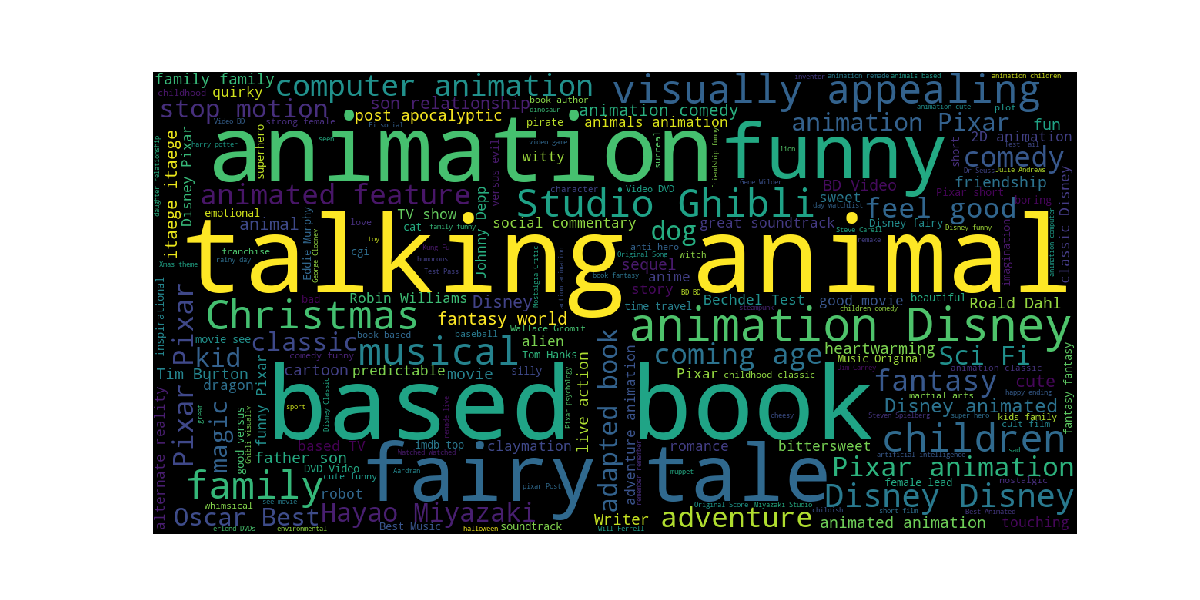

(-0.5, 1199.5, 599.5, -0.5)

In [52]:
# Generate a word cloud image
wordcloud = WordCloud(width=1200,height=600).generate(' '.join(children_tags['tag']))

# Display the generated image
plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.axis("off")